In [14]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [15]:
# Generate house size
num_house = 160
np.random.seed(42)
house_size = np.random.randint(low=1000, high=3500, size=num_house)

# Generate house price
np.random.seed(42)
house_price = house_size * 100.0 + np.random.randint(low=20000, high=70000, size=num_house)

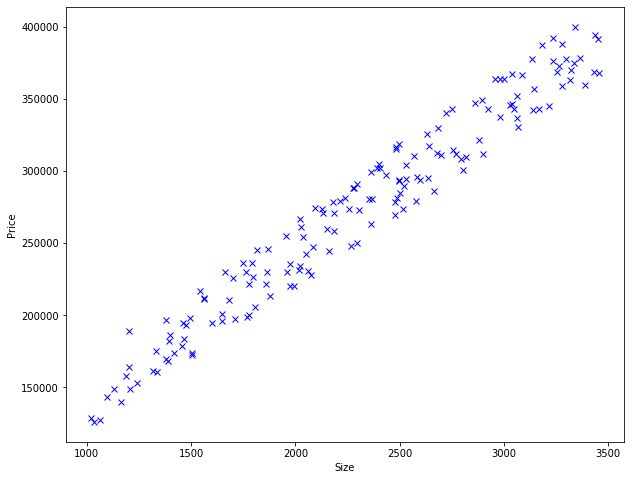

In [16]:
# Distribution of randomly generated data
plt.plot(house_size, house_price, "bx")
plt.ylabel("Price")
plt.xlabel("Size")
plt.show()

In [17]:
# normalize values to prevent under/overflows
def normalize(array):
    return (array - array.mean()) / array.std()

In [18]:
# define number of training samples, 0.7=70%. We can take the first
# 70% since the vals are randomized
num_train_samples = math.floor(num_house * 0.7)

In [19]:
# define train data
train_house_size = np.asarray(house_size[:num_train_samples])
train_price = np.asanyarray(house_price[:num_train_samples:])

train_house_size_norm = normalize(train_house_size)
train_price_norm = normalize(train_price)

# define test data
test_house_size = np.array(house_size[num_train_samples:])
test_house_price = np.array(house_price[num_train_samples:])

test_house_size_norm = normalize(test_house_size)
test_house_price_norm = normalize(test_house_price)

In [20]:
# set up TensorFlow placeholders that get updates as we descend down the gradient
tf_house_size = tf.placeholder("float", name="house_size")
tf_price = tf.placeholder("float", name="price")

tf_size_factor = tf.Variable(np.random.randn(), name="size-factor")
tf_price_offset = tf.Variable(np.random.randn(), name="price_offset")

In [21]:
# 2. Define the operations for the prediction values
tf_price_pred = tf.add(tf.multiply(tf_size_factor, tf_house_size), tf_price_offset)

In [22]:
# 3. Define the Loss Function (how much error) - Mean squared error
tf_cost = tf.reduce_sum(tf.pow(tf_price_pred-tf_price, 2))/(2*num_train_samples)

# optimizer learning rate. size of the steps down the gradient
learning_rate = 0.1

In [23]:
# 4. define a Gradient descent optimizer that will min the loss defined in the operation "cost"
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(tf_cost)

In [24]:
# Initialize the variables
init = tf.global_variables_initializer()

iteration #:  0002 cost =  0.720058858 size_factor =  0.091779955 price_offset =  -0.78197587
iteration #:  0004 cost =  0.488989949 size_factor =  0.2530591 price_offset =  -0.6400547
iteration #:  0006 cost =  0.334198892 size_factor =  0.38506955 price_offset =  -0.52387947
iteration #:  0008 cost =  0.230510548 size_factor =  0.4931228 price_offset =  -0.42877954
iteration #:  0010 cost =  0.161057353 size_factor =  0.5815667 price_offset =  -0.350931
iteration #:  0012 cost =  0.114538938 size_factor =  0.65396035 price_offset =  -0.2872049
iteration #:  0014 cost =  0.083384469 size_factor =  0.713216 price_offset =  -0.23503916
iteration #:  0016 cost =  0.062521778 size_factor =  0.76171756 price_offset =  -0.19233663
iteration #:  0018 cost =  0.048552588 size_factor =  0.8014175 price_offset =  -0.1573807
iteration #:  0020 cost =  0.039200630 size_factor =  0.8339127 price_offset =  -0.1287661
iteration #:  0022 cost =  0.032940891 size_factor =  0.86051065 price_offset =  -

AttributeError: 'function' object has no attribute 'FuncAnimation'

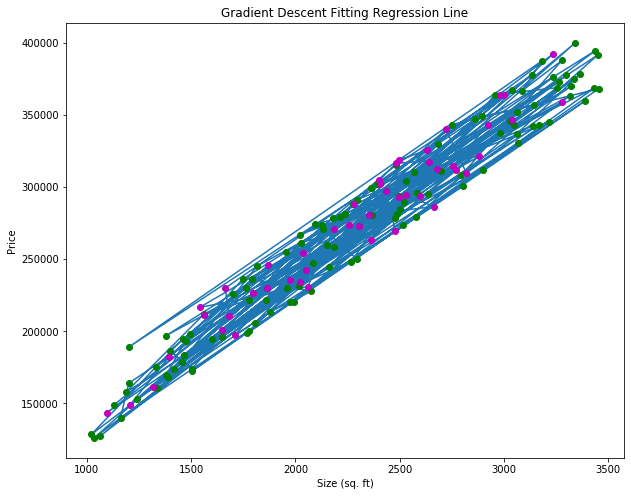

In [26]:
# Launch the graph in the session
with tf.Session() as sess:
    sess.run(init)

    display_every = 2
    num_training_iter = 50
    
    # Calculate the num of lines to animate
    fit_num_plots = math.floor(num_training_iter/display_every)
    # add storage of factor and offset vals from each epoch
    fit_size_factor = np.zeros(fit_num_plots)
    fit_price_offsets = np.zeros(fit_num_plots)
    fit_plot_idx = 0

    # keep iterating the training data
    for iteration in range(num_training_iter):

        # Fit all training data
        for (x, y) in zip(train_house_size_norm, train_price_norm):
            sess.run(optimizer, feed_dict={tf_house_size: x, tf_price: y})

        # Display current status
        if (iteration + 1) % display_every == 0:
            c = sess.run(tf_cost, feed_dict={tf_house_size: train_house_size_norm, tf_price:train_price_norm})
            print("iteration #: ", '%04d' % (iteration + 1), "cost = ", "{:.9f}".format(c), \
                              "size_factor = ", sess.run(tf_size_factor), "price_offset = ", sess.run(tf_price_offset))
            # Save the fit size_factor and price_offset to allow animation of learning process
            fit_size_factor[fit_plot_idx] = sess.run(tf_size_factor)
            fit_price_offsets[fit_plot_idx] = sess.run(tf_price_offset)
            fit_plot_idx = fit_plot_idx + 1
            
    print("Optimization Finished")
    print("Trained Cost = ", tf_cost, "size_factor", sess.run(tf_size_factor), "price_offset = ",
          sess.run(tf_price_offset), '\n')

    train_house_size_mean = train_house_size.mean()
    train_house_size_std = train_house_size.std()

    train_price_mean = train_price.mean()
    train_price_std = train_price.std()

    """# plot the graph
    plt.rcParams["figure.figsize"] = (10, 8)
    plt.figure()
    plt.ylabel("Price")
    plt.xlabel("Size (sq. ft)")
    plt.plot(train_house_size, train_price, 'go', label='Training data')
    plt.plot(test_house_size, test_house_price, 'mo', label='Testing data')
    plt.plot(train_house_size_norm * train_house_size_std + train_house_size_mean,
            (sess.run(tf_size_factor) * train_house_size_norm + sess.run(tf_price_offset)) * train_price_std + train_price_mean,
            label='Learned Regression')

    plt.legend(loc='upper left')
    plt.show()"""
    
    # Plot of training and test data, and linear regression
    
    # get values used to normalize data so we can denormalize data back to its original scale
    train_house_size_mean = train_house_size.mean()
    train_house_size_std = train_house_size.std()
    
    train_price_mean = train_price.mean()
    train_price_std = train_price.std()
    
    
    fig, ax = plt.subplots()
    line, = ax.plot(house_size, house_price)
    
    plt.rcParams["figure.figsize"] = (10, 8)
    plt.title("Gradient Descent Fitting Regression Line")
    plt.ylabel("Price")
    plt.xlabel("Size (sq. ft)")
    plt.plot(train_house_size, train_price, 'go', label='Training data')
    plt.plot(test_house_size, test_house_price, 'mo', label='Testing data')
    
    def animation(i):
        line.set_xdata(train_house_size_norm * train_house_size_std + train_house_size_mean) # update the data
        line.set_ydata((fit_size_factor[i] * train_house_size_norm + fit_price_offsets[i]) * train_price_std + train_price_mean)
        return line,
    
    
    def initAnim():
        line.set_ydata(np.zeros(shape=house_price.shape[0])) # set y's to 0
        return line,
    
    
    ani = animation.FuncAnimation(fig, animate, frames=np.arange(0, fit_plot_idx), init_func=initAnim,
                                 interval=1000, blit=True)
    
    
    plt.show()
    
